In [1]:
%matplotlib inline
from collections import defaultdict
import csv
import os
import sys

import matplotlib.pyplot
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import time
import pandas as pd
np.random.seed(42)

csv.field_size_limit(sys.maxsize);
cur_dir = '/home/rob/Udacity/capstone/data'

print cv2.__version__

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


3.2.0-dev


In [2]:
ClassNames = {'1':'buildings', '2':'Misc. Manmade structures', '3': 'Road', '4':'Track', '5':'Trees',
                    '6':'Crops', '7':'Waterway', '8':'Standing water', '9':'Vehicle Large ', '10':'Vehicle Small'}

save_masks = False


def get_scalers():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

def show_mask(m):
        
    tiff.imshow(255 * np.stack([m, m, m]));
    
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def partial_pipe_fit(pipeline_obj, xs, ys):
    xs = pipeline_obj.named_steps['standardscaler'].fit_transform(xs)
    pipeline_obj.named_steps['sgdclassifier'].partial_fit(xs,ys,[0,1])


class MY_SGDClassifier(SGDClassifier):
    def __init__(self, n_jobs=3, n_iter=1, loss='log'):
        super(MY_SGDClassifier, self).__init__(loss='log', penalty='l2', alpha=0.0001, 
                                               l1_ratio=0.15, fit_intercept=True, n_iter=n_iter, shuffle=True, 
                                               verbose=0, epsilon=0.1, n_jobs=n_jobs, random_state=None, 
                                               learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None, 
                                               warm_start=False, average=False)
    def fit(self, X, y, classes=[0,1], sample_weight=None):
        self.partial_fit(X,y,classes)
    

NameError: name 'SGDClassifier' is not defined

In [3]:
classifiers = {}
train_masks = {}
pred_masks = {}

trainIM_IDs = []
with open(cur_dir + '/train_wkt_v4.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar=',')
    for i,row in enumerate(reader):
        if i == 0:
            i = 1
        if (i%10) == 0:
            trainIM_IDs.append(row[0])
            
testIM_IDs = []
with open(cur_dir + '/sample_submission.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar=',')
    for i,row in enumerate(reader):
        if i == 0:
            i = 1
        if (i%10) == 0:
            testIM_IDs.append(row[0])

start with this stuff
should be done?


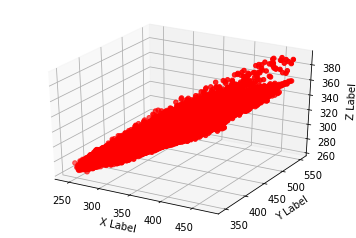

In [4]:
# Plot buildings pixels in train set
POLY_TYPE = str(1) # 1 - Buildings

for IM_ID in trainIM_IDs[:1]:
    
    im_rgb = tiff.imread(cur_dir +'/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0]) #gives back lists of lists
    im_size = im_rgb.shape[:2]

    train_polygons = None
    for _im_id, _poly_type, _poly in csv.reader(open(cur_dir + '/train_wkt_v4.csv')):
        if _im_id == IM_ID and _poly_type == POLY_TYPE:
            train_polygons = shapely.wkt.loads(_poly)
            break
            
    x_max = y_min = None
    for _im_id, _x, _y in csv.reader(open(cur_dir + '/grid_sizes.csv')):
        if _im_id == IM_ID:
            x_max, y_min = float(_x), float(_y)
            break    
    
    """
    # Read image with tiff
    im_rgb = tiff.imread(cur_dir +'/sixteen_band/{}_M.tif'.format(IM_ID)).transpose([1, 2, 0])
    im_size = im_rgb.shape[:2]
    img = np.zeros((im_rgb.shape[0],im_rgb.shape[1],3))
    img[:,:,0] = im_rgb[:,:,7] #red
    img[:,:,1] = im_rgb[:,:,4] #green
    img[:,:,2] = im_rgb[:,:,0] #blue
    im_rgb = img
    """
    x_scaler, y_scaler = get_scalers()
    
    train_polygons_scaled = shapely.affinity.scale(
        train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    
    train_mask = mask_for_polygons(train_polygons_scaled)

    
    xs = im_rgb.reshape(-1, 3).astype(np.float32)
    ys = train_mask.reshape(-1)
    data = xs.T
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    n = 100

    # For each set of style and range settings, plot n random points in the box
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    print "start with this stuff"
    
    xs = data[0]
    ys = data[1]
    zs = data[2]
    ax.scatter(xs, ys, zs, c='r', marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    print "should be done?"
    plt.show()

In [5]:
plt.show()